In [1]:
from google.colab import drive
path = '/content/drive'
drive.mount(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
filefolder=path + '/MyDrive/Perceptron_Hackathon/'
filepath = filefolder + 'Perceptron_ Team Success & Diversity.csv'

In [3]:
import pandas as pd, numpy as np, re, time
# Import algorithm libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

# hyperparameter training imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import spacy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, recall_score
from sklearn import tree
from os import system
#Visualization Libraries imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
#Need to select the option Runtime -> Restart and Run All. This is to ensure downloading Pandas profiling Libraries for Google Colab.
# Just run one time to use latest version

! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
! pip install --upgrade gensim

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (21.8 MB)


In [5]:
df = pd.read_csv(filepath)
df.head()

,Timestamp,BusinessName,Males,Females,TeamStrength,Country,BusinessAge,Rate your current team success,Rate the diversity in your team,Rate the inclusiveness in team,Rate how diversity in team is key to team success,isWomenOwned,MiniorityOwnedDesc
0,2022/05/12 10:52:09 pm GMT+5:30,anonymous,10,30,40,Brazil,30-40,3,4,3,4,0,Latinos
1,2022/05/13 1:46:06 pm GMT+5:30,eBay,20,5,25,USA,30-40,5,4,4,4,0,African_American
2,2022/05/13 1:46:53 pm GMT+5:30,Nvidia,30,25,55,Singapore,40-50,4,3,4,3,0,Asian
3,2022/05/13 1:47:52 pm GMT+5:30,anonymous,15,7,22,India,30-40,3,4,4,4,1,Female_total
4,2022/05/13 2:34:21 pm GMT+5:30,anonymous,8,12,20,Philippines,40-50,4,5,4,5,1,Asian_female


In [6]:
from pandas_profiling import ProfileReport
profile=ProfileReport(df)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df['MiniorityOwnedDesc'].unique()

array(['Latinos', 'African_American', 'Asian', 'Female_total',
       'Asian_female', 'African_American_female',
       'Hispanic_or_Latino_female', 'Women_of_color', 'White_female',
       'People_of_color', 'White', 'Native Americans'], dtype=object)

In [8]:
# We see that 'MiniorityOwnedDesc' has 12 unique categories of which most are diverse business owners. So encoding these businesses into two main categories based on our requirement.
# They are set as Diverse = 1 and Non-Diverse = 0

df = df.replace({'Latinos':1, 'African_American':1, 'Asian':1, 'Female_total':1, 'Asian_female':1, 'African_American_female':1, 'Hispanic_or_Latino_female':1, 'Women_of_color':1, 'White_female':0,'People_of_color':1, 'White':0, 'Native Americans':1})

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country' and 'BusinessAge'. 
#df['LE-MiniorityOwnedDesc']= label_encoder.fit_transform(df['MiniorityOwnedDesc'])
df['LE-Country']= label_encoder.fit_transform(df['Country']) 
df['LE-BusinessAge']= label_encoder.fit_transform(df['BusinessAge']) 
df.head()

,Timestamp,BusinessName,Males,Females,TeamStrength,Country,BusinessAge,Rate your current team success,Rate the diversity in your team,Rate the inclusiveness in team,Rate how diversity in team is key to team success,isWomenOwned,MiniorityOwnedDesc,LE-Country,LE-BusinessAge
0,2022/05/12 10:52:09 pm GMT+5:30,anonymous,10,30,40,Brazil,30-40,3,4,3,4,0,1,0,1
1,2022/05/13 1:46:06 pm GMT+5:30,eBay,20,5,25,USA,30-40,5,4,4,4,0,1,6,1
2,2022/05/13 1:46:53 pm GMT+5:30,Nvidia,30,25,55,Singapore,40-50,4,3,4,3,0,1,5,2
3,2022/05/13 1:47:52 pm GMT+5:30,anonymous,15,7,22,India,30-40,3,4,4,4,1,1,1,1
4,2022/05/13 2:34:21 pm GMT+5:30,anonymous,8,12,20,Philippines,40-50,4,5,4,5,1,1,4,2


In [10]:
#Dropping unwanted columns

df1 = df.drop(['Timestamp', 'BusinessName'], axis = 1)


In [11]:
# Creating a Diversity and Inclusiveness Index coolumn based on the average of 'Rate the diversity in your team' and 'Rate the inclusiveness in team'. As these columns contribute towards identifying diversity in a Bussiness / Team.
# This will be our Target feature to identify diversity in a business

#df1['DI_Index'] = df1[['Rate the diversity in your team', 'Rate the inclusiveness in team']].mean(axis=1)
#df1['DI_Index'] = round(df1['DI_Index'])
#df1['DI_Index'] = df1['DI_Index'].astype('int')
#df1.head()

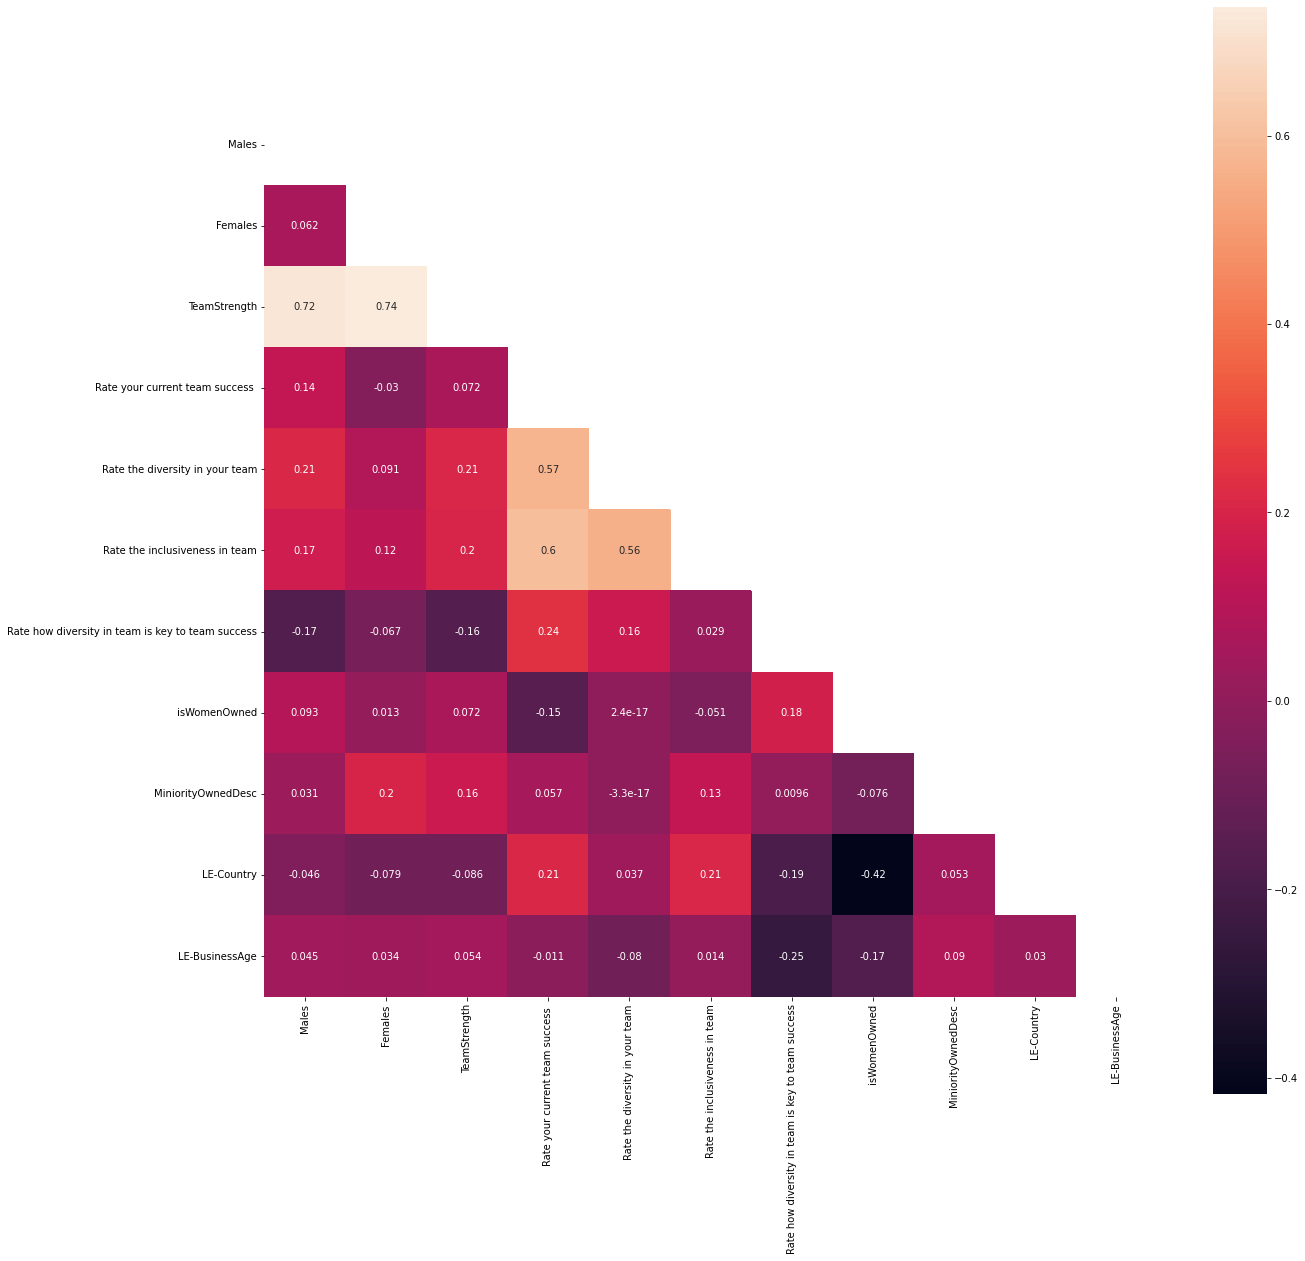

In [12]:
corr = df1.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask,annot=True,square=True)

## Performing Feaature selection based on the above Correlation graph.

### Removing the unimportant features
#### 1. isWomenOwned
#### 2. LE-BusinessAge

### Removing Duplicate Columns
#### 1. Rate the diversity in your team
#### 2. Rate the inclusiveness in team

### Removing Categorical columns
#### 1. MiniorityOwnedDesc
#### 2. Country
#### 3. BusinessAge

In [13]:
df1 = df1.drop(['isWomenOwned', 'LE-BusinessAge', 'Rate the diversity in your team', 'Rate the inclusiveness in team', 'Country', 'BusinessAge'], axis = 1)
df1.head()

,Males,Females,TeamStrength,Rate your current team success,Rate how diversity in team is key to team success,MiniorityOwnedDesc,LE-Country
0,10,30,40,3,4,1,0
1,20,5,25,5,4,1,6
2,30,25,55,4,3,1,5
3,15,7,22,3,4,1,1
4,8,12,20,4,5,1,4


In [14]:
X = df1.drop('MiniorityOwnedDesc',axis=1)
y = df1['MiniorityOwnedDesc']
y.value_counts()

1    50
0    10
Name: MiniorityOwnedDesc, dtype: int64

In [15]:
# Splitting Data into 70% Training data and 30% Testing Data:
X_train, X_test, y_train,  y_test = train_test_split(X, y,train_size=0.7, test_size=0.3, random_state=42)
print(len(X_train)),print(len(X_test))

42
18


(None, None)

In [16]:
# Chechking for null values in Training Set
X_train.isnull().sum().sum()

0

In [17]:
# Chechking for null values in Testing Set
X_test.isnull().sum().sum()

0

In [18]:
#Standardization of Data
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [19]:

# Building a Support Vector Machine Model

def SVC_Model(X,y):

    svc_model = SVC(C= .1, kernel='linear', gamma= 1)
    svc_model.fit(X_train, y_train)
    svc_predict = svc_model.predict(X_test)
    count_misclassified = (y_test != svc_predict).sum()
    
    print('SVC_Model_Confusion_Matrix:\n',confusion_matrix(y_test, svc_predict))
    print('SVC_Model_Classification_report:\n',classification_report(y_test, svc_predict))
    print('SVC_Model_Recall Score: ',recall_score(y_test, svc_predict))
    print('SVC_Model_ROC AUC: ', roc_auc_score(y_test, svc_predict))
    print('SVC_Model_Accuracy: ',accuracy_score(y_test, svc_predict))
    print('Misclassified samples in SVC_Model: {}'.format(count_misclassified))

#Building a Decision Tree Model

def dTreeR_Model(X,y):

    dTreeR = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state=1)
    dTreeR.fit(X_train, y_train)
    dTreeR_predict = dTreeR.predict(X_test)
    dTreeR_predictProba = dTreeR.predict_proba(X_test)
    count_misclassified = (y_test != dTreeR_predict).sum()

    print('DTree_Model_Confusion_Matrix:\n',confusion_matrix(y_test, dTreeR_predict))
    print('Dtree_Model_Classification_report:\n',classification_report(y_test, dTreeR_predict))
    print('Dtree_Model_Recall Score: ', recall_score(y_test, dTreeR_predict))
    print('Dtree_Model_ROC AUC: ', roc_auc_score(y_test, dTreeR_predictProba[:,1]))
    print('Dtree_Model_Accuracy: ',accuracy_score(y_test, dTreeR_predict))
    print('Misclassified samples in Dtree_Model: {}'.format(count_misclassified))
    

#Building a KNN model

def kNN_Model(X,y,n):
    
    knn_model = KNeighborsClassifier(n_neighbors= n , weights = 'distance' )
    knn_model.fit(X_train, y_train)
    knn_predict=knn_model.predict(X_test)
    knn_predictProb = knn_model.predict_proba(X_test)
    
    KNN_Model_Confusion_Matrix = confusion_matrix(y_test, knn_predict)
    KNN_Model_Accuracy = accuracy_score(y_test, knn_predict)
    count_misclassified = (y_test != knn_predict).sum()

    print('KNN_Model_Confusion_Matrix:\n',confusion_matrix(y_test, knn_predict))
    print('KNN_Model_Classification_report:\n',classification_report(y_test, knn_predict))
    print('KNN_Model_Recall Score: ', recall_score(y_test, knn_predict))
    print('KNN_Model_ROC AUC: ', roc_auc_score(y_test, knn_predictProb[:,1]))
    print('KNN_Model_Accuracy: ',accuracy_score(y_test, knn_predict))
    print('Misclassified samples in KNN_Model: {}'.format(count_misclassified))

In [20]:
SVC_Model(X,y)

SVC_Model_Confusion_Matrix:
 [[ 0  2]
 [ 0 16]]
SVC_Model_Classification_report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.89      1.00      0.94        16

    accuracy                           0.89        18
   macro avg       0.44      0.50      0.47        18
weighted avg       0.79      0.89      0.84        18

SVC_Model_Recall Score:  1.0
SVC_Model_ROC AUC:  0.5
SVC_Model_Accuracy:  0.8888888888888888
Misclassified samples in SVC_Model: 2


In [21]:
dTreeR_Model(X,y)

DTree_Model_Confusion_Matrix:
 [[ 1  1]
 [ 3 13]]
Dtree_Model_Classification_report:
               precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.93      0.81      0.87        16

    accuracy                           0.78        18
   macro avg       0.59      0.66      0.60        18
weighted avg       0.85      0.78      0.81        18

Dtree_Model_Recall Score:  0.8125
Dtree_Model_ROC AUC:  0.671875
Dtree_Model_Accuracy:  0.7777777777777778
Misclassified samples in Dtree_Model: 4


In [22]:
kNN_Model(X,y,3)

KNN_Model_Confusion_Matrix:
 [[ 0  2]
 [ 3 13]]
KNN_Model_Classification_report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.87      0.81      0.84        16

    accuracy                           0.72        18
   macro avg       0.43      0.41      0.42        18
weighted avg       0.77      0.72      0.75        18

KNN_Model_Recall Score:  0.8125
KNN_Model_ROC AUC:  0.453125
KNN_Model_Accuracy:  0.7222222222222222
Misclassified samples in KNN_Model: 5


In [23]:
#Building Ensemble Models
#Building Random Forest Model

#from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50, criterion='entropy', max_depth=5, random_state=5)
rfcl = rfcl.fit(X_train, y_train)
RandomF_predict = rfcl.predict(X_test)
RandomF_predictprob = rfcl.predict_proba(X_test)
count_misclassified = (y_test != RandomF_predict).sum()

print('RandomForest_Model_Classification_report:\n',classification_report(y_test, RandomF_predict))
print('RandomForest_Model_Accuracy: ',accuracy_score(y_test, RandomF_predict))
print('Misclassified samples in Random Forest: {}'.format(count_misclassified))

RandomForest_Model_Classification_report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.89      1.00      0.94        16

    accuracy                           0.89        18
   macro avg       0.44      0.50      0.47        18
weighted avg       0.79      0.89      0.84        18

RandomForest_Model_Accuracy:  0.8888888888888888
Misclassified samples in Random Forest: 2


In [24]:
7#Building Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.04)
gbcl = gbcl.fit(X_train,y_train)
gbcl_predict = gbcl.predict(X_test)
gbcl_predictprob = gbcl.predict_proba(X_test)
count_misclassified = (y_test != gbcl_predict).sum()

print('GradientBoosting_report:\n',classification_report(y_test, gbcl_predict))
print('GradientBoosting_Accuracy: ',accuracy_score(y_test, gbcl_predict))
print('Misclassified samples in GradientBoosting: {}'.format(count_misclassified))

GradientBoosting_report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.94      1.00      0.97        16

    accuracy                           0.94        18
   macro avg       0.97      0.75      0.82        18
weighted avg       0.95      0.94      0.94        18

GradientBoosting_Accuracy:  0.9444444444444444
Misclassified samples in GradientBoosting: 1


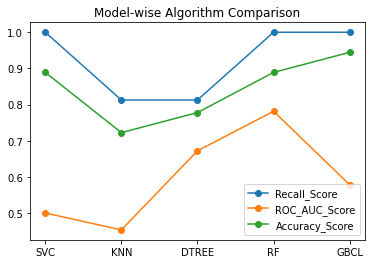

In [25]:
model_plot=pd.DataFrame()

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
svc_predict = svc_model.predict(X_test)

dTreeR = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state=1)
dTreeR.fit(X_train, y_train)
dTreeR_predict = dTreeR.predict(X_test)
dTreeR_predictProba = dTreeR.predict_proba(X_test)

knn_model = KNeighborsClassifier(n_neighbors= 3 , weights = 'distance' )
knn_model.fit(X_train, y_train)
knn_predict=knn_model.predict(X_test)
knn_predictProb = knn_model.predict_proba(X_test)

r1=recall_score(y_test, svc_predict)
r2=recall_score(y_test, knn_predict)
r3=recall_score(y_test, dTreeR_predict)
r4=recall_score(y_test, RandomF_predict)
r5=recall_score(y_test, gbcl_predict)
d1=pd.DataFrame({'SVC': [r1],'KNN': [r2],'DTREE': [r3],'RF': [r4],'GBCL': [r5]})

ra1=roc_auc_score(y_test, svc_predict)
ra2=roc_auc_score(y_test, knn_predictProb[:,1])
ra3=roc_auc_score(y_test, dTreeR_predictProba[:,1])
ra4=roc_auc_score(y_test, RandomF_predictprob[:,1])
ra5=roc_auc_score(y_test, gbcl_predictprob[:,1])
d2=pd.DataFrame({'SVC': [ra1],'KNN': [ra2],'DTREE': [ra3],'RF': [ra4],'GBCL': [ra5]})

a1=accuracy_score(y_test, svc_predict)
a2=accuracy_score(y_test, knn_predict)
a3=accuracy_score(y_test, dTreeR_predict)
a4=accuracy_score(y_test, RandomF_predict)
a5=accuracy_score(y_test, gbcl_predict)
d3=pd.DataFrame({'SVC': [a1],'KNN': [a2],'DTREE': [a3],'RF': [a4],'GBCL': [a5]})

model_plot = model_plot.append(d1)
model_plot = model_plot.append(d2)
model_plot = model_plot.append(d3)

fig, ax = plt.subplots()
plt.title('Model-wise Algorithm Comparison')
plt.plot(model_plot.T,'o-')
ax.legend(["Recall_Score", "ROC_AUC_Score","Accuracy_Score"], loc="lower right")


From the above visualization and we can see that **Gradient Boosting Classifier** has much higher accuracy compared to other algorithms and therefore is best suited for predicting Diversity Index of Business groups / Teams.